In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES
from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2019]

In [4]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
# load gdd/kdd from cpc temperature data
if wxData == 'gldas':
    gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    
    for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
        with gzip.open('%s/kdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
            curKdd = pickle.load(f)
            kdd[:, :, y] = curKdd

        with gzip.open('%s/gdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
            curGdd = pickle.load(f)
            gdd[:, :, y] = curGdd
    
    with gzip.open('%s/gdd-kdd-lat-cpc.dat'%(dataDirDiscovery), 'rb') as f:
        lat = pickle.load(f)

    with gzip.open('%s/gdd-kdd-lon-cpc.dat'%(dataDirDiscovery), 'rb') as f:
        lon = pickle.load(f)
        
elif wxData == 'era5':
    gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

    for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
        with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
            curKdd = pickle.load(f)
            kdd[:, :, y] = curKdd

        with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
            curGdd = pickle.load(f)
            gdd[:, :, y] = curGdd

    with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
        lat = pickle.load(f)

    with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
        lon = pickle.load(f)


In [6]:
if wxData == 'era5':

    with open('%s/seasonal-et-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalEvap = pickle.load(f)
    with open('%s/seasonal-t-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalT = pickle.load(f)
    with open('%s/seasonal-sshf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf = pickle.load(f)
    with open('%s/seasonal-slhf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf = pickle.load(f)
    with open('%s/seasonal-ssr-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr = pickle.load(f)
    with open('%s/seasonal-str-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr = pickle.load(f)
    with open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
        # m -> mm
        seasonalPrecip *= 1000
        seasonalPrecip[seasonalPrecip==0] = np.nan
    with open('%s/seasonal-u10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalU10 = pickle.load(f)
    with open('%s/seasonal-v10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalV10 = pickle.load(f)
    with open('%s/seasonal-seconds-maize.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSeconds = pickle.load(f)
        seasonalSeconds[seasonalSeconds<0] = -seasonalSeconds[seasonalSeconds<0]

elif wxData == 'gldas':
    with open('%s/seasonal-sshf-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf_Noah = -pickle.load(f)
    with open('%s/seasonal-slhf-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf_Noah = -pickle.load(f)
    with open('%s/seasonal-precip-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalPrecip_Noah = pickle.load(f)
    with open('%s/seasonal-str-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr_Noah = pickle.load(f)
    with open('%s/seasonal-ssr-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr_Noah = pickle.load(f)
    with open('%s/seasonal-wind-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalWind_Noah = pickle.load(f)

    with open('%s/seasonal-sshf-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf_Vic = -pickle.load(f)
    with open('%s/seasonal-slhf-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf_Vic = -pickle.load(f)
    with open('%s/seasonal-precip-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalPrecip_Vic = pickle.load(f)
    with open('%s/seasonal-str-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr_Vic = pickle.load(f)
    with open('%s/seasonal-ssr-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr_Vic = pickle.load(f)
    with open('%s/seasonal-wind-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalWind_Vic = pickle.load(f)
        
    seasonalSshf = (seasonalSshf_Noah + seasonalSshf_Vic)/2
    seasonalSlhf = (seasonalSlhf_Noah + seasonalSlhf_Vic)/2
    seasonalPrecip = (seasonalPrecip_Noah + seasonalPrecip_Vic)/2
    seasonalStr = (seasonalStr_Noah + seasonalStr_Vic)/2
    seasonalSsr = (seasonalSsr_Noah + seasonalSsr_Vic)/2
    seasonalWind = (seasonalWind_Noah + seasonalWind_Vic)/2


In [7]:

if wxData == 'era5':
    # calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
    with open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)
        kddTrends *= 10

    with open('%s/kdd-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrendSig = pickle.load(f)

    with open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
        gddTrends *= 10

    with open('%s/gdd-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrendSig = pickle.load(f)

    with open('%s/evap-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        evapTrends = pickle.load(f)
    
    with open('%s/t-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        tTrends = pickle.load(f)
        tTrends *= 10

    with open('%s/t-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        tTrendSig = pickle.load(f)
        
    with open('%s/pr-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends = pickle.load(f)
        prTrends *= 10 * 1000

    with open('%s/pr-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig = pickle.load(f)

    with open('%s/sshf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends = pickle.load(f)
        sshfTrends /= seasonalSeconds
        sshfTrends *= 10

    with open('%s/sshf-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig = pickle.load(f)

    with open('%s/slhf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends = pickle.load(f)
        slhfTrends /= seasonalSeconds
        slhfTrends *= 10

    with open('%s/slhf-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig = pickle.load(f)

    with open('%s/ef-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends = pickle.load(f)
        efTrends *= 10

    with open('%s/ef-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig = pickle.load(f)

    with open('%s/netrad-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends = pickle.load(f)
        netRadTrends /= seasonalSeconds
        netRadTrends *= 10

    with open('%s/netrad-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig = pickle.load(f)
        
elif wxData == 'gldas':
    # calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
    with open('%s/kdd-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)
        kddTrends *= 10

    with open('%s/kdd-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrendSig = pickle.load(f)

    with open('%s/gdd-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
        gddTrends *= 10

    with open('%s/gdd-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrendSig = pickle.load(f)

        
    with open('%s/pr-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends_Noah = pickle.load(f)
#         prTrends *= 10 * 1000
    with open('%s/pr-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig_Noah = pickle.load(f)
    with open('%s/pr-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends_Vic = pickle.load(f)
#         prTrends *= 10 * 1000
    with open('%s/pr-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig_Vic = pickle.load(f)
    prTrends = (prTrends_Noah + prTrends_Vic)/2
    prTrendSig = np.round((prTrendSig_Noah + prTrendSig_Vic)/2)
        
    with open('%s/sshf-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends_Noah = pickle.load(f)
        sshfTrends_Noah *= -10
    with open('%s/sshf-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig_Noah = pickle.load(f)
    with open('%s/sshf-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends_Vic = pickle.load(f)
        sshfTrends_Vic *= -10
    with open('%s/sshf-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig_Vic = pickle.load(f)
    sshfTrends = (sshfTrends_Noah + sshfTrends_Vic)/2
    sshfTrendSig = np.round((sshfTrendSig_Noah + sshfTrendSig_Vic)/2)
        
    with open('%s/slhf-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends_Noah = pickle.load(f)
        slhfTrends_Noah *= -10
    with open('%s/slhf-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig_Noah = pickle.load(f)
    with open('%s/slhf-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends_Vic = pickle.load(f)
        slhfTrends_Vic *= -10
    with open('%s/slhf-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig_Vic = pickle.load(f)
    slhfTrends = (slhfTrends_Noah + slhfTrends_Vic)/2
    slhfTrendSig = np.round((slhfTrendSig_Noah + slhfTrendSig_Vic)/2)
        
    with open('%s/ef-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends_Noah = pickle.load(f)
        efTrends_Noah *= 10
    with open('%s/ef-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig_Noah = pickle.load(f)
    with open('%s/ef-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends_Vic = pickle.load(f)
        efTrends_Vic *= 10
    with open('%s/ef-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig_Vic = pickle.load(f)
    efTrends = (efTrends_Noah + efTrends_Vic)/2
    efTrendSig = np.round((efTrendSig_Noah + efTrendSig_Vic)/2)
        
    with open('%s/netrad-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends_Noah = pickle.load(f)
        netRadTrends_Noah *= 10
    with open('%s/netrad-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig_Noah = pickle.load(f)
    with open('%s/netrad-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends_Vic = pickle.load(f)
        netRadTrends_Vic *= 10
    with open('%s/netrad-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig_Vic = pickle.load(f)
    netRadTrends = (netRadTrends_Noah + netRadTrends_Vic)/2
    netRadTrendSig = np.round((netRadTrendSig_Noah + netRadTrendSig_Vic)/2)

In [8]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dataDirDiscovery
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

In [9]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dataDirDiscovery)
sacksMaizeStart = sacksMaizeNc['plant'].values + 1
sacksMaizeStart = np.roll(sacksMaizeStart, -int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeStart[sacksMaizeStart < 0] = np.nan
sacksMaizeEnd = sacksMaizeNc['harvest'].values + 1
sacksMaizeEnd = np.roll(sacksMaizeEnd, -int(sacksMaizeEnd.shape[1]/2), axis=1)
sacksMaizeEnd[sacksMaizeEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

sacksSoybeanNc = xr.open_dataset('%s/sacks/Soybeans.crop.calendar.fill.nc'%dataDirDiscovery)
sacksSoybeanStart = sacksSoybeanNc['plant'].values + 1
sacksSoybeanStart = np.roll(sacksSoybeanStart, -int(sacksSoybeanStart.shape[1]/2), axis=1)
sacksSoybeanStart[sacksSoybeanStart < 0] = np.nan
sacksSoybeanEnd = sacksSoybeanNc['harvest'].values + 1
sacksSoybeanEnd = np.roll(sacksSoybeanEnd, -int(sacksSoybeanEnd.shape[1]/2), axis=1)
sacksSoybeanEnd[sacksSoybeanEnd < 0] = np.nan


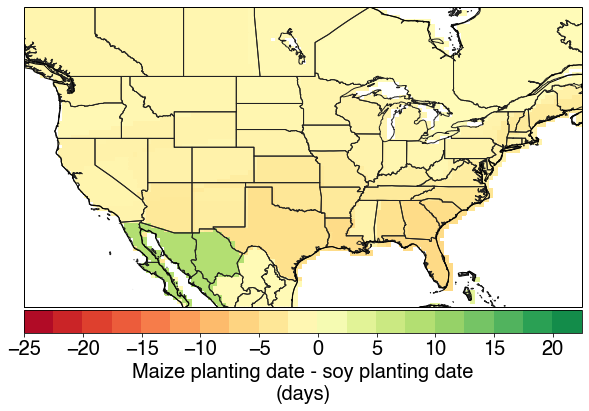

In [11]:
v1 = -25
v2 = 25
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('RdYlGn')

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])
c = plt.pcolormesh(sacksLon, sacksLat, sacksMaizeStart-sacksSoybeanStart, cmap=cmap)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('Maize planting date - soy planting date\n(days)', fontsize=20)
ax.coastlines()

plt.savefig('maize-vs-soy-plant.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

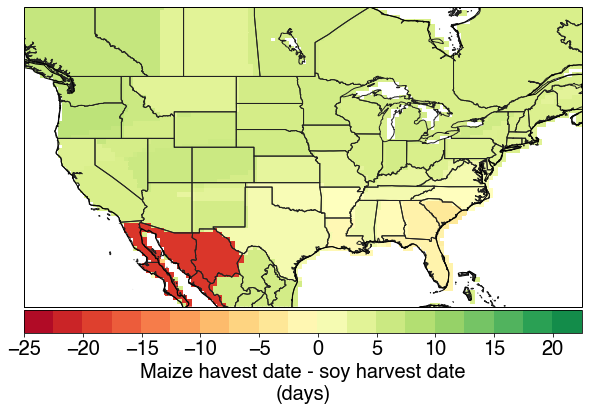

In [12]:
v1 = -25
v2 = 25
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('RdYlGn')

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])
c = plt.pcolormesh(sacksLon, sacksLat, sacksMaizeEnd-sacksSoybeanEnd, cmap=cmap)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('Maize havest date - soy harvest date\n(days)', fontsize=20)
ax.coastlines()

plt.savefig('maize-vs-soy-harvest.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

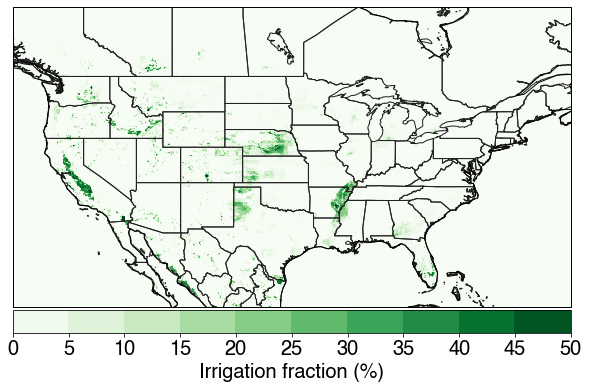

In [13]:
v1 = 0
v2 = 50.1
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])
c = plt.pcolormesh(irrigationLon, irrigationLat, irrigationData, cmap=cmap)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1,v2,vlabelstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('Irrigation fraction (%)', fontsize=20)
ax.coastlines()

plt.savefig('irr-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

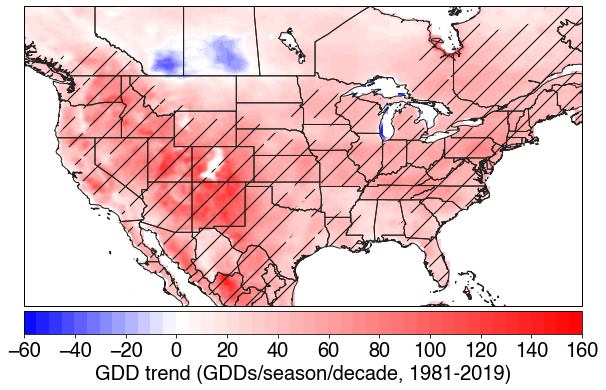

In [14]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -60
v2 = 161
vstep = 5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(lon, lat, gddTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('GDD trend (GDDs/season/decade, 1981-2019)', fontsize=20)
# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

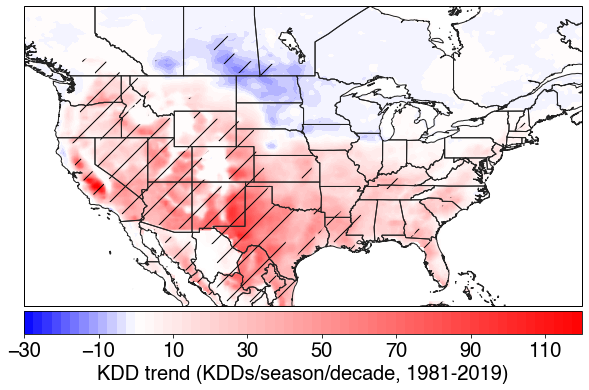

In [15]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -30
v2 = 121
vstep = 2.5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(lon, lat, kddTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(lon, lat, kddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('KDD trend (KDDs/season/decade, 1981-2019)', fontsize=20)
# if wxData == 'gldas':
#     plt.savefig('obs-kdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-kdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

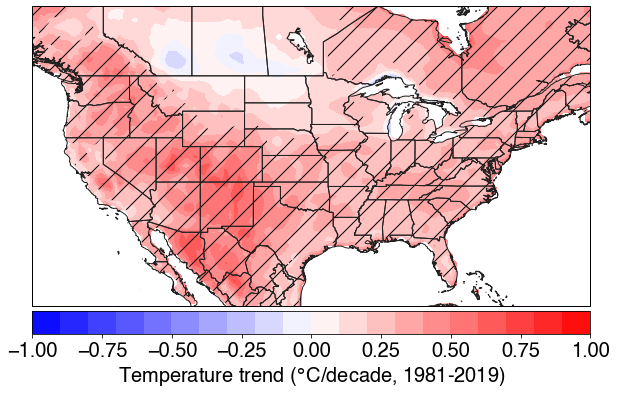

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, tTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, tTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Temperature trend ($\degree$C/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-t-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

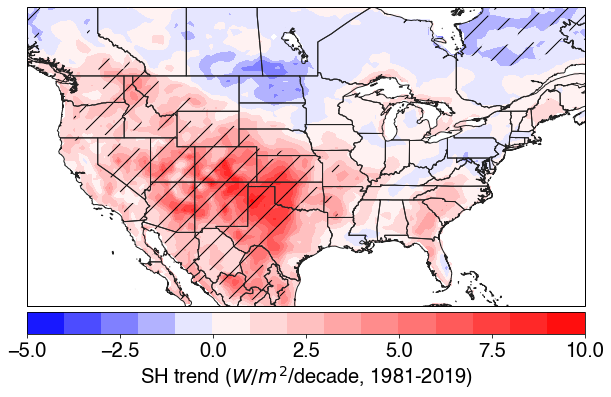

In [17]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -15
    v2 = 15.1
    vstep = 1
    vlabelstep = 5
else:
    v1 = -5
    v2 = 10.1
    vstep = 1
    vlabelstep = 2.5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, -sshfTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, sshfTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('SH trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-sh-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

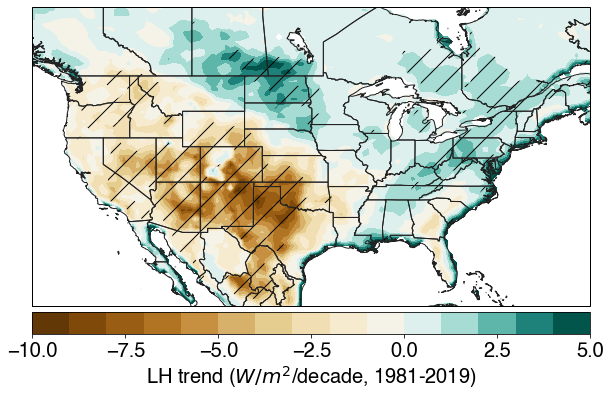

In [18]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -10
    v2 = 15.1
    vstep = 1
    vlabelstep = 5
else:
    v1 = -10
    v2 = 5.1
    vstep = 1
    vlabelstep = 2.5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, -slhfTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, slhfTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('LH trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-lh-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

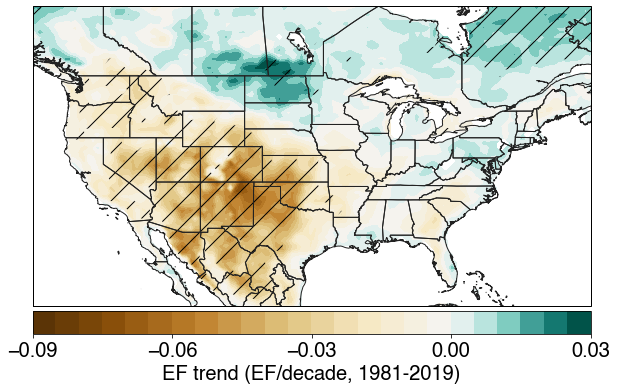

In [19]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -.09
    v2 = .121
    vstep = .005
    vlabelstep = .03
else:
    v1 = -.09
    v2 = .031
    vstep = .005
    vlabelstep = .03

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, efTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, efTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('EF trend (EF/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-ef-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

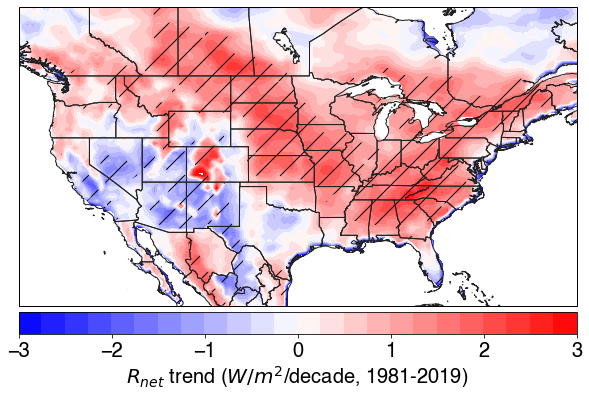

In [20]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -3
    v2 = 15.01
    vstep = 1
    vlabelstep = 3
else:
    v1 = -3
    v2 = 3.01
    vstep = .25
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, netRadTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, netRadTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('$R_{net}$ trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-netrad-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

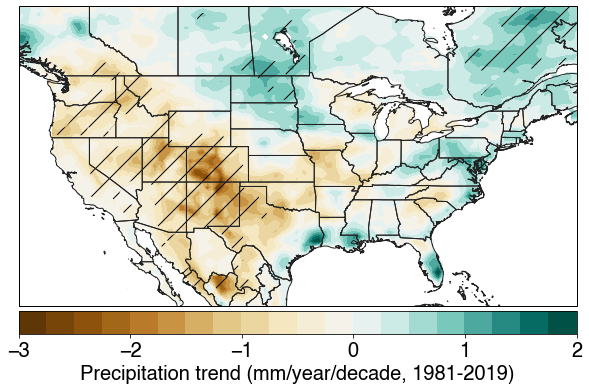

In [21]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -3
v2 = 2.1
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, prTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, prTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Precipitation trend (mm/year/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-pr-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [10]:
# load NASS yield data

nassCountyArea = pd.read_csv('%s/nass/maize-county-area.csv'%dataDirDiscovery)

nassMaizePlantedArea1 = pd.read_csv('%s/nass/maize-area-planted-1961-1974.csv'%dataDirDiscovery)
nassMaizePlantedArea2 = pd.read_csv('%s/nass/maize-area-planted-1975-1994.csv'%dataDirDiscovery)
nassMaizePlantedArea3 = pd.read_csv('%s/nass/maize-area-planted-1995-2019.csv'%dataDirDiscovery)
nassMaizePlantedArea = pd.concat([nassMaizePlantedArea1[::-1], nassMaizePlantedArea2[::-1], nassMaizePlantedArea3[::-1]])

nassMaizeHarvestedArea1 = pd.read_csv('%s/nass/maize-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassMaizeHarvestedArea2 = pd.read_csv('%s/nass/maize-area-harvested-1970-1981.csv'%dataDirDiscovery)
nassMaizeHarvestedArea3 = pd.read_csv('%s/nass/maize-area-harvested-1982-2001.csv'%dataDirDiscovery)
nassMaizeHarvestedArea4 = pd.read_csv('%s/nass/maize-area-harvested-2002-2019.csv'%dataDirDiscovery)
nassMaizeHarvestedArea = pd.concat([nassMaizeHarvestedArea1[::-1], nassMaizeHarvestedArea2[::-1], \
                                    nassMaizeHarvestedArea3[::-1], nassMaizeHarvestedArea4[::-1]])

nassSoybeanHarvestedArea1 = pd.read_csv('%s/nass/soybean-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea2 = pd.read_csv('%s/nass/soybean-area-harvested-1970-1995.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea3 = pd.read_csv('%s/nass/soybean-area-harvested-1996-2019.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea = pd.concat([nassSoybeanHarvestedArea1[::-1], nassSoybeanHarvestedArea2[::-1], \
                                    nassSoybeanHarvestedArea3[::-1]])

nassMaizeProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassMaizeProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassMaizeProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassMaizeProd = pd.concat([nassMaizeProd1[::-1], nassMaizeProd2[::-1], nassMaizeProd3[::-1]])

nassMaizeYield1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nassMaizeYield2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nassMaizeYield3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)
nassMaizeYield = pd.concat([nassMaizeYield1[::-1], nassMaizeYield2[::-1], nassMaizeYield3[::-1]])

nassSoybeanYield1 = pd.read_csv('%s/nass/soybean-yield-1961-1989.csv'%dataDirDiscovery)
nassSoybeanYield2 = pd.read_csv('%s/nass/soybean-yield-1990-2019.csv'%dataDirDiscovery)
nassSoybeanYield = pd.concat([nassSoybeanYield1[::-1], nassSoybeanYield2[::-1]])



In [11]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [12]:
nassMaizeStates = list(nassMaizeYield['State'])
nassMaizeStateAbvs = []
for s in nassMaizeStates:
    nassMaizeStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeYield['StateAbvs'] = nassMaizeStateAbvs

nassSoybeanStates = list(nassSoybeanYield['State'])
nassSoybeanStateAbvs = []
for s in nassSoybeanStates:
    nassSoybeanStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanYield['StateAbvs'] = nassSoybeanStateAbvs

nassMaizeProdStates = list(nassMaizeProd['State'])
nassMaizeProdStateAbvs = []
for s in nassMaizeProdStates:
    nassMaizeProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeProd['StateAbvs'] = nassMaizeProdStateAbvs

nassMaizePlantedAreaStates = list(nassMaizePlantedArea['State'])
nassMaizePlantedAreaStateAbvs = []
for s in nassMaizePlantedAreaStates:
    nassMaizePlantedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizePlantedArea['StateAbvs'] = nassMaizePlantedAreaStateAbvs

nassMaizeHarvestedAreaStates = list(nassMaizeHarvestedArea['State'])
nassMaizeHarvestedAreaStateAbvs = []
for s in nassMaizeHarvestedAreaStates:
    nassMaizeHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeHarvestedArea['StateAbvs'] = nassMaizeHarvestedAreaStateAbvs

nassSoybeanHarvestedAreaStates = list(nassSoybeanHarvestedArea['State'])
nassSoybeanHarvestedAreaStateAbvs = []
for s in nassSoybeanHarvestedAreaStates:
    nassSoybeanHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanHarvestedArea['StateAbvs'] = nassSoybeanHarvestedAreaStateAbvs

nassCountyAreaStates = list(nassCountyArea['State'])
nassCountyAreaStateAbvs = []
for s in nassCountyAreaStates:
    nassCountyAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassCountyArea['StateAbvs'] = nassCountyAreaStateAbvs

In [13]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [14]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [15]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=False

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvap'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSeconds'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalT'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSshf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSlhf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalEf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSsr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalStr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalNetRad'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalU10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalV10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanPlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestDate'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeCountyArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeCountyIrrigationFraction'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanYield'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360
            

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
    
        irrLatInds = [np.where(abs(irrigationLat-lat2) == np.nanmin(abs(irrigationLat-lat2)))[0][0],
                   np.where(abs(irrigationLat-lat1) == np.nanmin(abs(irrigationLat-lat1)))[0][0]]
        irrLonInds = [np.where(abs(irrigationLon-lon1) == np.nanmin(abs(irrigationLon-lon1)))[0][0],
                   np.where(abs(irrigationLon-lon2) == np.nanmin(abs(irrigationLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            continue

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(countyMaizeYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(countyMaizeYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyMaizeYieldDeepak = np.pad(countyMaizeYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)
        
        irrLatIndsRange = np.arange(min(irrLatInds), max(irrLatInds)+1)
        irrLonIndsRange = np.arange(min(irrLonInds), max(irrLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
            countyT = np.nanmean(seasonalT[prLatIndsRange, :, :], axis=0)
            countySshf = np.nanmean(seasonalSshf[prLatIndsRange, :, :], axis=0)
            countySlhf = np.nanmean(seasonalSlhf[prLatIndsRange, :, :], axis=0)
            countySsr = np.nanmean(seasonalSsr[prLatIndsRange, :, :], axis=0)
            countyStr = np.nanmean(seasonalStr[prLatIndsRange, :, :], axis=0)
            
            if 'gldas' in wxData:
                countyU10 = np.nanmean(seasonalWind_Noah[prLatIndsRange, :, :], axis=0)
                countyV10 = np.nanmean(seasonalWind_Noah[prLatIndsRange, :, :], axis=0)
            else:
                countyU10 = np.nanmean(seasonalU10[prLatIndsRange, :, :], axis=0)
                countyV10 = np.nanmean(seasonalV10[prLatIndsRange, :, :], axis=0)
                
            if wxData == 'era5':
                countySeasonalSeconds = np.nanmean(seasonalSeconds[prLatIndsRange, :], axis=0)
            
            countyMaizePlantDate = np.nanmean(sacksMaizeStart[prLatIndsRange, :], axis=0)
            countySoybeanPlantDate = np.nanmean(sacksSoybeanStart[prLatIndsRange, :], axis=0)
            countyMaizeHarvestDate = np.nanmean(sacksMaizeEnd[prLatIndsRange, :], axis=0)
            countySoybeanHarvestDate = np.nanmean(sacksSoybeanEnd[prLatIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])
            countyT = np.squeeze(seasonalT[prLatIndsRange, :, :])
            countySshf = np.squeeze(seasonalSshf[prLatIndsRange, :, :])
            countySlhf = np.squeeze(seasonalSlhf[prLatIndsRange, :, :])
            countySsr = np.squeeze(seasonalSsr[prLatIndsRange, :, :])
            countyStr = np.squeeze(seasonalStr[prLatIndsRange, :, :])
            
            if 'gldas' in wxData:
                countyU10 = np.squeeze(seasonalWind_Noah[prLatIndsRange, :, :])
                countyV10 = np.squeeze(seasonalWind_Noah[prLatIndsRange, :, :])
            else:
                countyU10 = np.squeeze(seasonalU10[prLatIndsRange, :, :])
                countyV10 = np.squeeze(seasonalV10[prLatIndsRange, :, :])
            
            if wxData == 'era5':
                countySeasonalSeconds = np.squeeze(seasonalSeconds[prLatIndsRange, :])
            
            countyMaizePlantDate = np.squeeze(sacksMaizeStart[prLatIndsRange, :])
            countySoybeanPlantDate = np.squeeze(sacksSoybeanStart[prLatIndsRange, :])
            countyMaizeHarvestDate = np.squeeze(sacksMaizeEnd[prLatIndsRange, :])
            countySoybeanHarvestDate = np.squeeze(sacksSoybeanEnd[prLatIndsRange, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
            countyT = np.nanmean(countyT[prLonIndsRange, :], axis=0)
            countySshf = np.nanmean(countySshf[prLonIndsRange, :], axis=0)
            countySlhf = np.nanmean(countySlhf[prLonIndsRange, :], axis=0)
            countySsr = np.nanmean(countySsr[prLonIndsRange, :], axis=0)
            countyStr = np.nanmean(countyStr[prLonIndsRange, :], axis=0)
            countyU10 = np.nanmean(countyU10[prLonIndsRange, :], axis=0)
            countyV10 = np.nanmean(countyV10[prLonIndsRange, :], axis=0)                
            
            if wxData == 'era5':
                countySeasonalSeconds = np.nanmean(countySeasonalSeconds[prLonIndsRange], axis=0)
            
            countyMaizePlantDate = np.nanmean(countyMaizePlantDate[prLonIndsRange], axis=0)
            countySoybeanPlantDate = np.nanmean(countySoybeanPlantDate[prLonIndsRange], axis=0)
            countyMaizeHarvestDate = np.nanmean(countyMaizeHarvestDate[prLonIndsRange], axis=0)
            countySoybeanHarvestDate = np.nanmean(countySoybeanHarvestDate[prLonIndsRange], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])
            countyT = np.squeeze(countyT[prLonIndsRange, :])
            countySshf = np.squeeze(countySshf[prLonIndsRange, :])
            countySlhf = np.squeeze(countySlhf[prLonIndsRange, :])
            countySsr = np.squeeze(countySsr[prLonIndsRange, :])
            countyStr = np.squeeze(countyStr[prLonIndsRange, :])
            countyU10 = np.squeeze(countyU10[prLonIndsRange, :])
            countyV10 = np.squeeze(countyV10[prLonIndsRange, :])
            
            if wxData == 'era5':
                countySeasonalSeconds = np.squeeze(countySeasonalSeconds[prLonIndsRange])
            
            countyMaizePlantDate = np.squeeze(countyMaizePlantDate[prLonIndsRange])
            countySoybeanPlantDate = np.squeeze(countySoybeanPlantDate[prLonIndsRange])
            countyMaizeHarvestDate = np.squeeze(countyMaizeHarvestDate[prLonIndsRange])
            countySoybeanHarvestDate = np.squeeze(countySoybeanHarvestDate[prLonIndsRange])

        if wxData == 'era5':
            usCounties['seasonalSeconds'][c] = countySeasonalSeconds
        
        usCounties['maizePlantingDate'][c] = countyMaizePlantDate
        usCounties['soybeanPlantingDate'][c] = countySoybeanPlantDate
        usCounties['maizeHarvestDate'][c] = countyMaizeHarvestDate
        usCounties['soybeanHarvestDate'][c] = countySoybeanHarvestDate
            
        if len(irrLatIndsRange) > 1:
            countyIrrigation = np.nanmean(irrigationData[irrLatIndsRange, :], axis=0)
        else:
            countyIrrigation = np.squeeze(irrigationData[irrLatIndsRange, :])
        
        if len(irrLonIndsRange) > 1:
            countyIrrigation = np.nanmean(countyIrrigation[irrLonIndsRange])
        else:
            countyIrrigation = np.squeeze(countyIrrigation[irrLonIndsRange])
        
        usCounties['maizeCountyIrrigationFraction'][c] = countyIrrigation
        
        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassMaizeYieldCounties = np.array(list(map(str.lower, nassMaizeYield['County'])))
        nassMaizeProdCounties = np.array(list(map(str.lower, nassMaizeProd['County'])))
        nassMaizePlantedAreaCounties = np.array(list(map(str.lower, nassMaizePlantedArea['County'])))
        nassMaizeHarvestedAreaCounties = np.array(list(map(str.lower, nassMaizeHarvestedArea['County'])))
        nassCountyAreaCounties = np.array(list(map(str.lower, nassCountyArea['County'])))
        
        curStateName = usCounties['STATE'][c].lower()
        nassMaizeYieldStates = np.array(list(map(str.lower, nassMaizeYield['StateAbvs'])))
        nassMaizeProdStates = np.array(list(map(str.lower, nassMaizeProd['StateAbvs'])))
        nassMaizePlantedAreaStates = np.array(list(map(str.lower, nassMaizePlantedArea['StateAbvs'])))
        nassMaizeHarvestedAreaStates = np.array(list(map(str.lower, nassMaizeHarvestedArea['StateAbvs'])))
        nassCountyAreaStates = np.array(list(map(str.lower, nassCountyArea['StateAbvs'])))

        countyIndMaizeYield = np.where((curCountyName == nassMaizeYieldCounties) & (curStateName == nassMaizeYieldStates))[0]
        countyIndMaizeProd = np.where((curCountyName == nassMaizeProdCounties) & (curStateName == nassMaizeProdStates))[0]
        countyIndMaizePlantedArea = np.where((curCountyName == nassMaizePlantedAreaCounties) & (curStateName == nassMaizePlantedAreaStates))[0]
        countyIndMaizeHarvestedArea = np.where((curCountyName == nassMaizeHarvestedAreaCounties) & (curStateName == nassMaizeHarvestedAreaStates))[0]
        countyIndCountyArea = np.where((curCountyName == nassCountyAreaCounties) & (curStateName == nassCountyAreaStates))[0]

        curCountyMaizeYieldYears = np.array(list(nassMaizeYield['Year']))
        curCountyMaizeYieldYears = curCountyMaizeYieldYears[countyIndMaizeYield]

        curCountyMaizeYield = np.array(list(nassMaizeYield['Value']))
        curCountyMaizeYield = curCountyMaizeYield[countyIndMaizeYield]
        
        curCountyMaizeProdYears = np.array(list(nassMaizeProd['Year']))
        curCountyMaizeProdYears = curCountyMaizeProdYears[countyIndMaizeProd]
        
        curCountyMaizeProd = np.array(list(nassMaizeProd['Value']))
        curCountyMaizeProd = curCountyMaizeProd[countyIndMaizeProd]
        
        curCountyMaizePlantedAreaYears = np.array(list(nassMaizePlantedArea['Year']))
        curCountyMaizePlantedAreaYears = curCountyMaizePlantedAreaYears[countyIndMaizePlantedArea]
        
        curCountyMaizePlantedArea = np.array(list(nassMaizePlantedArea['Value']))
        curCountyMaizePlantedArea = curCountyMaizePlantedArea[countyIndMaizePlantedArea]
        
        curCountyMaizeHarvestedAreaYears = np.array(list(nassMaizeHarvestedArea['Year']))
        curCountyMaizeHarvestedAreaYears = curCountyMaizeHarvestedAreaYears[countyIndMaizeHarvestedArea]
        
        curCountyMaizeHarvestedArea = np.array(list(nassMaizeHarvestedArea['Value']))
        curCountyMaizeHarvestedArea = curCountyMaizeHarvestedArea[countyIndMaizeHarvestedArea]
        
        
        nassSoybeanYieldCounties = np.array(list(map(str.lower, nassSoybeanYield['County'])))
        nassSoybeanHarvestedAreaCounties = np.array(list(map(str.lower, nassSoybeanHarvestedArea['County'])))

        nassSoybeanYieldStates = np.array(list(map(str.lower, nassSoybeanYield['StateAbvs'])))
        nassSoybeanHarvestedAreaStates = np.array(list(map(str.lower, nassSoybeanHarvestedArea['StateAbvs'])))
        
        countyIndSoybeanYield = np.where((curCountyName == nassSoybeanYieldCounties) & (curStateName == nassSoybeanYieldStates))[0]
        countyIndSoybeanHarvestedArea = np.where((curCountyName == nassSoybeanHarvestedAreaCounties) & (curStateName == nassSoybeanHarvestedAreaStates))[0]
        
        curCountySoybeanYieldYears = np.array(list(nassSoybeanYield['Year']))
        curCountySoybeanYieldYears = curCountySoybeanYieldYears[countyIndSoybeanYield]

        curCountySoybeanYield = np.array(list(nassSoybeanYield['Value']))
        curCountySoybeanYield = curCountySoybeanYield[countyIndSoybeanYield]
        
        curCountySoybeanHarvestedAreaYears = np.array(list(nassSoybeanHarvestedArea['Year']))
        curCountySoybeanHarvestedAreaYears = curCountySoybeanHarvestedAreaYears[countyIndSoybeanHarvestedArea]
        
        curCountySoybeanHarvestedArea = np.array(list(nassSoybeanHarvestedArea['Value']))
        curCountySoybeanHarvestedArea = curCountySoybeanHarvestedArea[countyIndSoybeanHarvestedArea]
        
        
        curCountyArea = np.array(list(nassCountyArea['Value']))
        curCountyArea = curCountyArea[countyIndCountyArea]
        curCountyArea = np.nanmean([float(a.replace(',','')) for a in curCountyArea])
        usCounties['maizeCountyArea'][c] = curCountyArea

        
        # MAIZE-------------------------------------------------------
        
        maizeYieldYearsUniform = np.arange(1981, 2019+1)
        maizeYieldUniform = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrend = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNorm = np.full(maizeYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyMaizeYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeYieldYearsUniform):
                maizeYieldUniform[indUniform] = curCountyMaizeYield[y]
        
        maizeProdYearsUniform = np.arange(1981, 2019+1)
        maizeProdUniform = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrend = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrendNorm = np.full(maizeProdYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeProdYearsUniform):
                maizeProdUniform[indUniform] = float(curCountyMaizeProd[y].replace(',', ''))
        
        maizePlantedAreaYearsUniform = np.arange(1981, 2019+1)
        maizePlantedAreaUniform = np.full(maizePlantedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizePlantedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizePlantedAreaYearsUniform):
                maizePlantedAreaUniform[indUniform] = float(curCountyMaizePlantedArea[y].replace(',', ''))
        
        maizeHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        maizeHarvestedAreaUniform = np.full(maizeHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeHarvestedAreaYearsUniform):
                tmpStr = curCountyMaizeHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    maizeHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    maizeHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(maizeYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            maizeYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(maizeYieldUniform[indsNass]))
            maizeYieldUniformDetrend[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass])
            maizeYieldUniform[:ptMax[0]] = np.nan
            maizeYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(maizeYieldUniform[indsNass])))
            mdl = sm.OLS(maizeYieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
        
        ptMaxProd = findConsec(maizeProdUniform)
        if ptMaxProd[1]-ptMaxProd[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMaxProd[0], ptMaxProd[1])
            maizeProdUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass]) / \
                                                    np.linalg.norm(scipy.signal.detrend(maizeProdUniform[indsNass]))
            maizeProdUniformDetrend[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass])
            
            maizeProdUniform[:ptMaxProd[0]] = np.nan
            maizeProdUniform[ptMaxProd[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1])))
                mdl = sm.OLS(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        ptMaxPlantedArea = findConsec(maizePlantedAreaUniform)
        if ptMaxPlantedArea[1]-ptMaxPlantedArea[0]+1 >= minCropYears:
            maizePlantedAreaUniform[:ptMaxPlantedArea[0]] = np.nan
            maizePlantedAreaUniform[ptMaxPlantedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1])))
                mdl = sm.OLS(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1], X).fit()
                usCounties['maizePlantedAreaTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(maizeHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            maizeHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            maizeHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['maizeHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = maizeYieldYearsUniform
        usCounties['maizeYield'][c] = maizeYieldUniform
        usCounties['maizeYieldDetrend'][c] = maizeYieldUniformDetrend
        usCounties['maizeYieldDetrendPlusMean'][c] = maizeYieldUniformDetrend + np.nanmean(maizeYieldUniform)
        usCounties['maizeYieldDetrendNorm'][c] = maizeYieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = maizeProdYearsUniform
        
        usCounties['maizeProd'][c] = maizeProdUniform
        usCounties['maizeProdDetrend'][c] = maizeProdUniformDetrend
        usCounties['maizeProdDetrendNorm'][c] = maizeProdUniformDetrendNorm
        
        usCounties['maizePlantedAreaYears'][c] = maizePlantedAreaYearsUniform
        usCounties['maizePlantedArea'][c] = maizePlantedAreaUniform
        usCounties['maizePlantedAreaFraction'][c] = maizePlantedAreaUniform/curCountyArea
        
        usCounties['maizeHarvestedAreaYears'][c] = maizeHarvestedAreaYearsUniform
        usCounties['maizeHarvestedArea'][c] = maizeHarvestedAreaUniform
        usCounties['maizeHarvestedAreaFraction'][c] = maizeHarvestedAreaUniform/curCountyArea
            
        # do the same but with deepak data            
        maizeYieldUniformDetrendDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNormDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyMaizeYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            maizeYieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]) / \
                                                                np.linalg.norm(scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]))
            maizeYieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak])
            countyMaizeYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyMaizeYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyMaizeYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyMaizeYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyMaizeYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = maizeYieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendPlusMeanDeepak'][c] = maizeYieldUniformDetrendDeepak + np.nanmean(countyMaizeYieldDeepak)
        usCounties['maizeYieldDetrendNormDeepak'][c] = maizeYieldUniformDetrendNormDeepak
        
        # SOYBEAN-------------------------------------------------------
        
        soybeanYieldYearsUniform = np.arange(1981, 2019+1)
        soybeanYieldUniform = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrend = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrendNorm = np.full(soybeanYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountySoybeanYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanYieldYearsUniform):
                soybeanYieldUniform[indUniform] = curCountySoybeanYield[y]
        
        soybeanHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        soybeanHarvestedAreaUniform = np.full(soybeanHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountySoybeanHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanHarvestedAreaYearsUniform):
                tmpStr = curCountySoybeanHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    soybeanHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    soybeanHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(soybeanYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            soybeanYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(soybeanYieldUniform[indsNass]))
            soybeanYieldUniformDetrend[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass])
            soybeanYieldUniform[:ptMax[0]] = np.nan
            soybeanYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(soybeanYieldUniform[indsNass])))
            mdl = sm.OLS(soybeanYieldUniform[indsNass], X).fit()
            usCounties['soybeanYieldTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(soybeanHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            soybeanHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            soybeanHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['soybeanHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['soybeanYieldYears'][c] = soybeanYieldYearsUniform
        usCounties['soybeanYield'][c] = soybeanYieldUniform
        usCounties['soybeanYieldDetrend'][c] = soybeanYieldUniformDetrend
        usCounties['soybeanYieldDetrendPlusMean'][c] = soybeanYieldUniformDetrend + np.nanmean(soybeanYieldUniform)
        usCounties['soybeanYieldDetrendNorm'][c] = soybeanYieldUniformDetrendNorm
        
        usCounties['soybeanHarvestedAreaYears'][c] = soybeanHarvestedAreaYearsUniform
        usCounties['soybeanHarvestedArea'][c] = soybeanHarvestedAreaUniform
        usCounties['soybeanHarvestedAreaFraction'][c] = soybeanHarvestedAreaUniform/curCountyArea
        
        # WX VARIABLES -------------------------------------------------------------------
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        if len(indsPr) == len(countyPrecip):
            usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
            usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
            usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))
            X = sm.add_constant(range(len(countyPrecip[indsPr])))
            mdl = sm.OLS(countyPrecip[indsPr], X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
        
        indsT = np.where(~np.isnan(countyT))[0]
        usCounties['seasonalT'][c] = np.full(countyT.shape, np.nan)
        usCounties['seasonalTDetrend'][c] = np.full(countyT.shape, np.nan)
        usCounties['seasonalTDetrendNorm'][c] = np.full(countyT.shape, np.nan)
        if len(indsT) == len(countyT):
            usCounties['seasonalT'][c][indsT] = countyT[indsT]
            usCounties['seasonalTDetrend'][c][indsT] = scipy.signal.detrend(countyT[indsT]) 
            usCounties['seasonalTDetrendNorm'][c][indsT] = scipy.signal.detrend(countyT[indsT]) / np.linalg.norm(scipy.signal.detrend(countyT[indsT]))
            X = sm.add_constant(range(len(countyT[indsT])))
            mdl = sm.OLS(countyT[indsT], X).fit()
            usCounties['seasonalTTrend'][c] = mdl.params[1]
        
        
        indsSshf = np.where(~np.isnan(countySshf))[0]
        usCounties['seasonalSshf'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrend'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrendNorm'][c] = np.full(countySshf.shape, np.nan)
        if len(indsSshf) == len(countySshf):
            usCounties['seasonalSshf'][c][indsSshf] = countySshf[indsSshf]
            usCounties['seasonalSshfDetrend'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) 
            usCounties['seasonalSshfDetrendNorm'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) / np.linalg.norm(scipy.signal.detrend(countySshf[indsSshf]))
            X = sm.add_constant(range(len(countySshf[indsSshf])))
            mdl = sm.OLS(countySshf[indsSshf], X).fit()
            usCounties['seasonalSshfTrend'][c] = mdl.params[1]
        
        indsSlhf = np.where(~np.isnan(countySlhf))[0]
        usCounties['seasonalSlhf'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrend'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrendNorm'][c] = np.full(countySlhf.shape, np.nan)
        if len(indsSlhf) == len(countySlhf):
            usCounties['seasonalSlhf'][c][indsSlhf] = countySlhf[indsSlhf]        
            usCounties['seasonalSlhfDetrend'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) 
            usCounties['seasonalSlhfDetrendNorm'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) / np.linalg.norm(scipy.signal.detrend(countySlhf[indsSlhf]))
            X = sm.add_constant(range(len(countySlhf[indsSlhf])))
            mdl = sm.OLS(countySlhf[indsSlhf], X).fit()
            usCounties['seasonalSlhfTrend'][c] = mdl.params[1]
        
        countyEf = countySlhf/(countySlhf+countySshf)
        indsEf = np.where(~np.isnan(countyEf))[0]
        usCounties['seasonalEf'][c] = np.full(countyEf.shape, np.nan)
        usCounties['seasonalEfDetrend'][c] = np.full(countyEf.shape, np.nan)
        if len(indsEf) == len(countyEf):
            usCounties['seasonalEf'][c][indsEf] = countyEf[indsEf]        
            usCounties['seasonalEfDetrend'][c][indsEf] = scipy.signal.detrend(countyEf[indsEf]) 
            X = sm.add_constant(range(len(countyEf[indsEf])))
            mdl = sm.OLS(countyEf[indsEf], X).fit()
            usCounties['seasonalEfTrend'][c] = mdl.params[1]
        
        
        indsSsr = np.where(~np.isnan(countySsr))[0]
        usCounties['seasonalSsr'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrend'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrendNorm'][c] = np.full(countySsr.shape, np.nan)
        if len(indsSsr) == len(countySsr):
            usCounties['seasonalSsr'][c][indsSsr] = countySsr[indsSsr]
            usCounties['seasonalSsrDetrend'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) 
            usCounties['seasonalSsrDetrendNorm'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) / np.linalg.norm(scipy.signal.detrend(countySsr[indsSsr]))
            X = sm.add_constant(range(len(countySsr[indsSsr])))
            mdl = sm.OLS(countySsr[indsSsr], X).fit()
            usCounties['seasonalSsrTrend'][c] = mdl.params[1]
        
        
        indsStr = np.where(~np.isnan(countyStr))[0]
        usCounties['seasonalStr'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrend'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrendNorm'][c] = np.full(countyStr.shape, np.nan)
        if len(indsStr) == len(countyStr):
            usCounties['seasonalStr'][c][indsStr] = countyStr[indsStr]
            usCounties['seasonalStrDetrend'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) 
            usCounties['seasonalStrDetrendNorm'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) / np.linalg.norm(scipy.signal.detrend(countyStr[indsStr]))
            X = sm.add_constant(range(len(countyStr[indsStr])))
            mdl = sm.OLS(countyStr[indsStr], X).fit()
            usCounties['seasonalStrTrend'][c] = mdl.params[1]
            
        countyNetRad = countyStr+countySsr
        indsNetRad = np.where(~np.isnan(countyNetRad))[0]
        usCounties['seasonalNetRad'][c] = np.full(countyNetRad.shape, np.nan)
        usCounties['seasonalNetRadDetrend'][c] = np.full(countyNetRad.shape, np.nan)
        usCounties['seasonalNetRadDetrendNorm'][c] = np.full(countyNetRad.shape, np.nan)
        if len(indsNetRad) == len(countyNetRad):
            usCounties['seasonalNetRad'][c][indsNetRad] = countyNetRad[indsNetRad]
            usCounties['seasonalNetRadDetrend'][c][indsNetRad] = scipy.signal.detrend(countyNetRad[indsNetRad]) 
            usCounties['seasonalNetRadDetrendNorm'][c][indsNetRad] = scipy.signal.detrend(countyNetRad[indsNetRad]) / np.linalg.norm(scipy.signal.detrend(countyNetRad[indsNetRad]))
            X = sm.add_constant(range(len(countyNetRad[indsNetRad])))
            mdl = sm.OLS(countyNetRad[indsNetRad], X).fit()
            usCounties['seasonalNetRadTrend'][c] = mdl.params[1]
        
        indsU10 = np.where(~np.isnan(countyU10))[0]
        usCounties['seasonalU10'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10Detrend'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10DetrendNorm'][c] = np.full(countyU10.shape, np.nan)
        if len(indsU10) == len(countyU10):
            usCounties['seasonalU10'][c][indsU10] = countyU10[indsU10]
            usCounties['seasonalU10Detrend'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) 
            usCounties['seasonalU10DetrendNorm'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) / np.linalg.norm(scipy.signal.detrend(countyU10[indsU10]))
            X = sm.add_constant(range(len(countyU10[indsU10])))
            mdl = sm.OLS(countyU10[indsU10], X).fit()
            usCounties['seasonalU10Trend'][c] = mdl.params[1]
        
        
        indsV10 = np.where(~np.isnan(countyV10))[0]
        usCounties['seasonalV10'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10Detrend'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10DetrendNorm'][c] = np.full(countyV10.shape, np.nan)
        if len(indsV10) == len(countyV10):
            usCounties['seasonalV10'][c][indsV10] = countyV10[indsV10]
            usCounties['seasonalV10Detrend'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) 
            usCounties['seasonalV10DetrendNorm'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) / np.linalg.norm(scipy.signal.detrend(countyV10[indsV10]))
            X = sm.add_constant(range(len(countyV10[indsV10])))
            mdl = sm.OLS(countyV10[indsV10], X).fit()
            usCounties['seasonalV10Trend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [16]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [17]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [18]:
usCounties = usCounties.drop(index=inds)

In [19]:
# load the feedback analysis to get the final selected counties

useDeepak = False

with gzip.open('cc-feedback-analysis-100-100-new.dat', 'rb') as f:
    ccFeedbackAnalysis = pickle.load(f)

In [20]:
fipsSel = ccFeedbackAnalysis['fipsSel']
irSel = ccFeedbackAnalysis['irSel']

mdl_LH_Y_Coefs = ccFeedbackAnalysis['mdl_LH_Y_Coefs']
mdl_LH_Y_PValues = ccFeedbackAnalysis['mdl_LH_Y_PValues']

lhTrendFrac = ccFeedbackAnalysis['lhTrendFrac']
lhFromFeedback = ccFeedbackAnalysis['lhFromFeedback']
lhChgFeedbackWithAgInt = ccFeedbackAnalysis['lhChgFeedbackWithAgInt']
lhChgFeedbackWithoutAgInt = ccFeedbackAnalysis['lhChgFeedbackWithoutAgInt']

shTrendFrac = ccFeedbackAnalysis['shTrendFrac']
shFromFeedback = ccFeedbackAnalysis['shFromFeedback']
shChgFeedbackWithAgInt = ccFeedbackAnalysis['shChgFeedbackWithAgInt']
shChgFeedbackWithoutAgInt = ccFeedbackAnalysis['shChgFeedbackWithoutAgInt']

gddTrendFrac = ccFeedbackAnalysis['gddTrendFrac']
gddFromFeedback = ccFeedbackAnalysis['gddFromFeedback']
gddChgFeedbackWithAgInt = ccFeedbackAnalysis['gddChgFeedbackWithAgInt']
gddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['gddChgFeedbackWithoutAgInt']

kddTrendFrac = ccFeedbackAnalysis['kddTrendFrac']
kddFromFeedback = ccFeedbackAnalysis['kddFromFeedback']
kddChgFeedbackWithAgInt = ccFeedbackAnalysis['kddChgFeedbackWithAgInt']
kddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['kddChgFeedbackWithoutAgInt']

maizeYieldTrendFrac = ccFeedbackAnalysis['maizeYieldTrendFrac']
maizeYieldFromFeedback = ccFeedbackAnalysis['maizeYieldFromFeedback']
maizeYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithAgInt']
maizeYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithoutAgInt']

soybeanYieldTrendFrac = ccFeedbackAnalysis['soybeanYieldTrendFrac']
soybeanYieldFromFeedback = ccFeedbackAnalysis['soybeanYieldFromFeedback']
soybeanYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithAgInt']
soybeanYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithoutAgInt']

tFromFeedback = ccFeedbackAnalysis['tFromFeedback']



In [21]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below

curCountyList = usCounties.copy()

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeAllAc + haSoybeanAllAc
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

meanPrAll = np.array([np.nanmean(a) for a in usCounties['seasonalPrecip']])

meanNetRadAll = np.array([np.nanmean(a) for a in usCounties['seasonalNetRad']])
meanSlhfAll = -np.array([np.nanmean(a) for a in usCounties['seasonalSlhf']])

if wxData == 'era5':
    countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
    meanNetRadAll /= countySeasonLenSec
    meanSlhfAll /= countySeasonLenSec

meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
netRadTrendAll = np.array([a for a in usCounties['seasonalNetRadTrend']])

if wxData == 'era5':
    slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]
    sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]
    netRadTrendAll = [a*10/t for a,t in zip(netRadTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldStdAll = np.array([np.nanstd(a) for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    maizeYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    soybeanYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    for c in range(maizeYieldAll.shape[0]):
        nn = np.where(~np.isnan(maizeYieldAll[c,:]))[0]
        if np.nansum(maizeYieldAll[c,nn]) > 0:
            maizeYieldStdAll[c] = np.nanstd(scipy.signal.detrend(maizeYieldAll[c,nn]))
        
        nn = np.where(~np.isnan(soybeanYieldAll[c,:]))[0]
        if np.nansum(soybeanYieldAll[c,nn]) > 0:
            soybeanYieldStdAll[c] = np.nanstd(scipy.signal.detrend(soybeanYieldAll[c,nn]))
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
    maizeProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)])
    totalProdMeanLast5All = np.full(totalProdMeanAll.shape, np.nan)
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    totalProdOverTimeAll = np.full(maizeYieldAll.shape[1]-1, 0)
    totalHaTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        
        totalProdMeanLast5All[c] = np.nanmean(p_maize[nn_maize[-5:]]) + np.nanmean(p_soybean[nn_soybean[-5:]])
        
        for y in range(totalProdOverTimeAll.shape[0]):
            if ~np.isnan(p_maize[y]):
                totalProdOverTimeAll[y] += p_maize[y]
            if ~np.isnan(p_soybean[y]):
                totalProdOverTimeAll[y] += p_soybean[y]
        
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(countyMaizeHaAc[c,nn_maize],X).fit()
            totalHaTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(countySoybeanHaAc[c, nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalHaTrendAll[c] = mdl.params[1]
            else:
                totalHaTrendAll[c] += mdl.params[1]

nn = np.where((totalProdTrendAll > 0) & \
              (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
              (~np.isnan(haTotalFracAll)) & \
              (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnIr = np.where((totalProdTrendAll > 0) & \
                (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                (~np.isnan(haTotalFracAll)) & (~np.isnan(irSel)) & \
                (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnNonIr = np.where((totalProdTrendAll > 0) & \
                   (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                   (~np.isnan(haTotalFracAll)) & \
                   (np.isnan(irSel)) & \
                   (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnAll = np.where((~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                   (~np.isnan(haTotalFracAll)) & \
                   (np.isnan(irSel)))[0]
# noOutlierInd = np.where((abs(scipy.stats.zscore(lhFromFeedback[nn]/haTotalFracAll[nn])) < 1))[0]
adjNn = nn#[noOutlierInd]
# adjNnIr = np.intersect1d(adjNn, irSel)


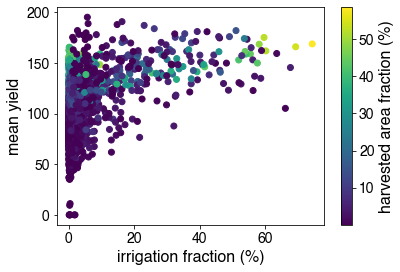

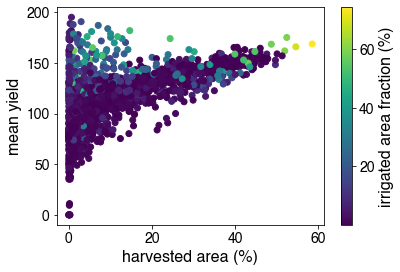

In [89]:
pa = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
yt = np.array([a for a in usCounties['maizeYield']])
pa = np.nanmean(pa,axis=1)*100
yt = np.nanmean(yt,axis=1)
plt.figure()
plt.scatter(ir,yt,c=pa)
plt.xlabel('irrigation fraction (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('harvested area fraction (%)')

plt.figure()
plt.scatter(pa,yt,c=ir)
plt.xlabel('harvested area (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('irrigated area fraction (%)')

In [90]:
yt = []
kt = []
pr = []
sh = []
lh = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 2: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrendDeepak'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        sh.append(usCounties[usCounties['STATE']==state]['seasonalSshfTrend'].mean().mean())
        lh.append(usCounties[usCounties['STATE']==state]['seasonalSlhfTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']


In [91]:
countyMaizeYield = np.array(list(usCounties['maizeYield']))[adjNn]
countySoybeanYield = np.array(list(usCounties['soybeanYield']))[adjNn]

yield_series_lengths_maize = []
yield_series_lengths_soy = []

for c in range(countyMaizeYield.shape[0]):
    yield_series_lengths_maize.append(len(np.where(~np.isnan(countyMaizeYield[c,:]))[0]))
    yield_series_lengths_soy.append(len(np.where(~np.isnan(countySoybeanYield[c,:]))[0]))

yield_series_lengths_maize = np.array(yield_series_lengths_maize)
yield_series_lengths_soy = np.array(yield_series_lengths_soy)

In [92]:
len(yield_series_lengths_soy[yield_series_lengths_soy<30])

1

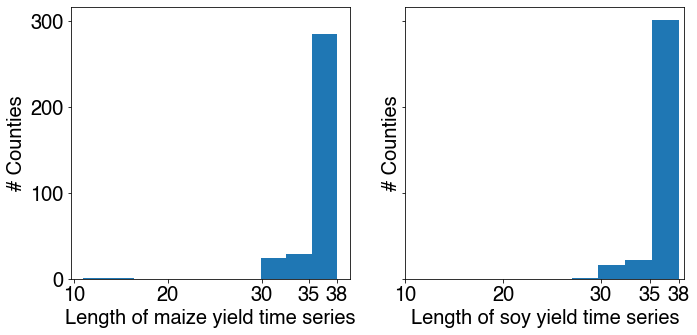

In [93]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11,5))

ax1.hist(yield_series_lengths_maize, bins=10)
# ax1.set_ylim([0, 2400])
# ax1.set_xlim([2.2, 3.3])
# ax1.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d))], [0, 2400], '--k', lw=2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xticks([10, 20, 30, 35, 38])
ax1.set_xlabel('Length of maize yield time series', fontsize=20)
ax1.set_ylabel('# Counties', fontsize=20)


ax2.hist(yield_series_lengths_soy, bins=4)
# ax1.set_ylim([0, 2400])
# ax1.set_xlim([2.2, 3.3])
# ax1.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d))], [0, 2400], '--k', lw=2)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xticks([10, 20, 30, 35, 38])
ax2.set_xlabel('Length of soy yield time series', fontsize=20)
ax2.set_ylabel('# Counties', fontsize=20)

plt.savefig('yield-time-series-lengths.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

yield trend vs. kdd trend: coef = -1.28, p = 0.00, r2 = 0.11


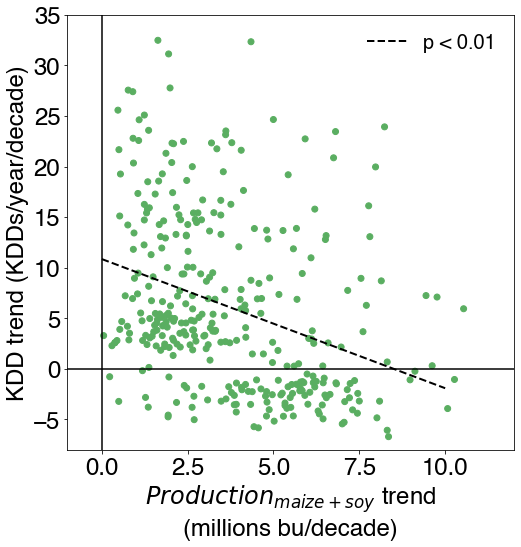

In [94]:

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])[adjNn]
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])[adjNn]

countyMaizeYield = np.array(list(usCounties['maizeYield']))[adjNn]
countySoybeanYield = np.array(list(usCounties['soybeanYield']))[adjNn]

countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
countyProdTrend = np.full([countySoybeanYield.shape[0]], np.nan)
for c in range(countyTotalProd.shape[0]):
    p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
    p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
    countyTotalProd[c,:] = p_maize + p_soybean
    
    nn = np.where(~np.isnan(countyTotalProd[c,:]))[0]
    if len(nn) >= 10:
        X = sm.add_constant(range(len(countyTotalProd[c,nn])))
        mdl1 = sm.OLS(countyTotalProd[c,nn], X).fit()
        countyProdTrend[c] = mdl1.params[1]/1e6*10

kddTrendAgg = np.array([x*10 for x in usCounties['kddTrend']])[adjNn]
nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(countyProdTrend)))[0]
kddTrendAgg = kddTrendAgg[nn]
countyProdTrend = countyProdTrend[nn]
    
f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(countyProdTrend)
mdl1 = sm.OLS(kddTrendAgg, X).fit()

x1 = 0
x2 = 10

cmap = plt.cm.get_cmap('PRGn')

ax1.set_xlim([-1, 12])
ax1.set_ylim([-8, 35])
ax1.scatter(countyProdTrend, kddTrendAgg, c = [cmap(.8)]*len(kddTrendAgg))
ax1.plot([x1, x2], mdl1.params[0]+[x1*mdl1.params[1], x2*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-5, 20], [0, 0], '-k')
ax1.plot([0, 0], [-11, 80], '-k')
ax1.set_xlabel('$Production_{maize+soy}$ trend\n(millions bu/decade)', fontsize=24)
ax1.set_ylabel('KDD trend (KDDs/year/decade)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
plt.savefig('us-kdd-trends-prod-trends-analysis-region.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

print('yield trend vs. kdd trend: coef = %.2f, p = %.2f, r2 = %.2f'%(mdl1.params[1], mdl1.pvalues[1], mdl1.rsquared))


yield trend vs. kdd trend: coef = -1.57, p = 0.00, r2 = 0.10


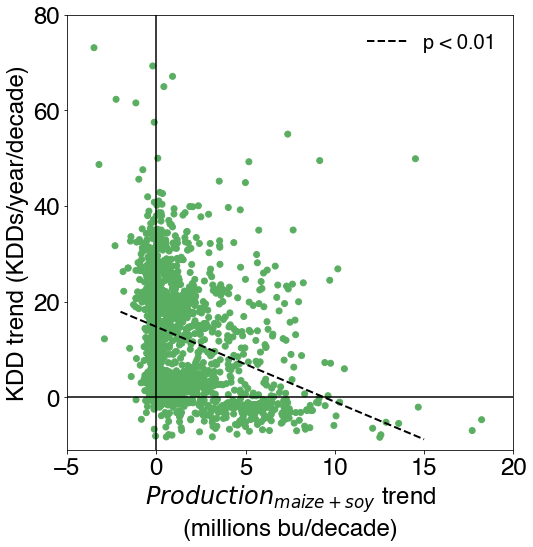

In [95]:

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYield = np.array(list(usCounties['maizeYield']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))

countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
countyProdTrend = np.full([countySoybeanYield.shape[0]], np.nan)
for c in range(countyTotalProd.shape[0]):
    p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
    p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
    countyTotalProd[c,:] = p_maize + p_soybean
    
    nn = np.where(~np.isnan(countyTotalProd[c,:]))[0]
    if len(nn) >= 10:
        X = sm.add_constant(range(len(countyTotalProd[c,nn])))
        mdl1 = sm.OLS(countyTotalProd[c,nn], X).fit()
        countyProdTrend[c] = mdl1.params[1]/1e6*10

kddTrendAgg = np.array([x*10 for x in usCounties['kddTrend']])
nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(countyProdTrend)))[0]
kddTrendAgg = kddTrendAgg[nn]
countyProdTrend = countyProdTrend[nn]
    
f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(countyProdTrend)
mdl1 = sm.OLS(kddTrendAgg, X).fit()

x1 = -2
x2 = 15

cmap = plt.cm.get_cmap('PRGn')

ax1.set_xlim([-5, 20])
ax1.set_ylim([-11, 80])
ax1.scatter(countyProdTrend, kddTrendAgg, c = [cmap(.8)]*len(kddTrendAgg))
ax1.plot([x1, x2], mdl1.params[0]+[x1*mdl1.params[1], x2*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-5, 20], [0, 0], '-k')
ax1.plot([0, 0], [-11, 80], '-k')
ax1.set_xlabel('$Production_{maize+soy}$ trend\n(millions bu/decade)', fontsize=24)
ax1.set_ylabel('KDD trend (KDDs/year/decade)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('us-kdd-trends-prod-trends.eps', format='eps', dpi=100, bbox_inches = 'tight', pad_inches = 0)

print('yield trend vs. kdd trend: coef = %.2f, p = %.2f, r2 = %.2f'%(mdl1.params[1], mdl1.pvalues[1], mdl1.rsquared))


In [96]:
np.array(list(usCounties['maizeHarvestedAreaFraction']))[adjNn,:].shape

(340, 39)

In [104]:
curCountyList = usCounties.copy()

def normWithNan(x):
    x1d = np.reshape(x, [x.size])
    nn = np.where(~np.isnan(x1d))[0]
    x1d = x1d[nn]
    x_norm = x.copy()/np.linalg.norm(x1d)
    return x_norm

ha = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])[adjNn, :]
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])[adjNn]
ha = np.nanmean(ha,axis=1)*100

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))[adjNn, :]])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))[adjNn, :]])
countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))[adjNn, :]])*100
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))[adjNn, :]])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))[adjNn, :]])
countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))[adjNn, :]])*100

countyMaizeYield = np.array(list(curCountyList['maizeYield']))[adjNn, :]
countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))[adjNn, :]

countySoybeanYield = np.array(list(curCountyList['soybeanYield']))[adjNn, :]
countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))[adjNn, :]

countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
for c in range(countyTotalProd.shape[0]):
    p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
    p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
    countyTotalProd[c,:] = p_maize + p_soybean
    countyTotalProd[c,:] = normWithNan(countyTotalProd[c,:])

kddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['kddDetrendNorm']))[adjNn, :]])))
gddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['gddDetrendNorm']))[adjNn, :]])))
prAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalPrecipDetrendNorm']))[adjNn, :]])))
sshfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSshfDetrendNorm']))[adjNn, :]])))
slhfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSlhfDetrendNorm']))[adjNn, :]])))

ssrAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSsrDetrendNorm']))[adjNn, :]])))
strAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalStrDetrendNorm']))[adjNn, :]])))

u10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalU10DetrendNorm']))[adjNn, :]])))
v10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalV10DetrendNorm']))[adjNn, :]])))

seasonalTAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalTDetrendNorm']))[adjNn, :]])))

maizeYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['maizeYieldDetrendNorm']))[adjNn, :]])))
soybeanYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['soybeanYieldDetrendNorm']))[adjNn, :]])))
countyTotalProdAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in countyTotalProd])))


countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(ha))])))

nn = np.where((~np.isnan(kddAnomNormAgg)) & (~np.isnan(prAnomNormAgg)) & \
              (~np.isnan(maizeYieldAnomNormAgg) | ~np.isnan(soybeanYieldAnomNormAgg)) & (~np.isnan(sshfAnomNormAgg)) & (~np.isnan(slhfAnomNormAgg)))[0]

kddAnomNormAgg = kddAnomNormAgg[nn]
gddAnomNormAgg = gddAnomNormAgg[nn]
sshfAnomNormAgg = sshfAnomNormAgg[nn]
slhfAnomNormAgg = slhfAnomNormAgg[nn]
ssrAnomNormAgg = ssrAnomNormAgg[nn]
strAnomNormAgg = strAnomNormAgg[nn]

u10AnomNormAgg = u10AnomNormAgg[nn]
v10AnomNormAgg = v10AnomNormAgg[nn]
seasonalTAnomNormAgg = seasonalTAnomNormAgg[nn]

prAnomNormAgg = prAnomNormAgg[nn]
maizeYieldAnomNormAgg = maizeYieldAnomNormAgg[nn]
soybeanYieldAnomNormAgg = soybeanYieldAnomNormAgg[nn]
countyTotalProdAnomNormAgg = countyTotalProdAnomNormAgg[nn]

data = {'KDD':kddAnomNormAgg, \
        'GDD':gddAnomNormAgg, \
        'SSHF':-sshfAnomNormAgg, \
        'SLHF':-slhfAnomNormAgg, \
        'SSR':ssrAnomNormAgg, \
        'STR':strAnomNormAgg, \
        'NetRad':(ssrAnomNormAgg+strAnomNormAgg), \
        'U10':-u10AnomNormAgg, \
        'V10':-v10AnomNormAgg, \
        'Pr':prAnomNormAgg, \
        'T':seasonalTAnomNormAgg, \
        'MaizeYield':maizeYieldAnomNormAgg, \
        'SoybeanYield':soybeanYieldAnomNormAgg, \
        'TotalProd':countyTotalProdAnomNormAgg}

df = pd.DataFrame(data, \
                  columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'NetRad', 'Pr', 'T', 'U10', 'V10', \
                           'MaizeYield', 'SoybeanYield', 'TotalProd'])


mdl1 = smf.ols(formula='SLHF ~ TotalProd + Pr + NetRad + U10 + V10', data=df).fit()
mdl2 = smf.ols(formula='SLHF ~ TotalProd + Pr + NetRad + KDD + U10 + V10', data=df).fit()
mdl3 = smf.ols(formula='SLHF ~ TotalProd + Pr + NetRad + T', data=df).fit()
mdl4 = smf.ols(formula='SLHF ~ TotalProd + Pr + T', data=df).fit()
mdl5 = smf.ols(formula='SLHF ~ TotalProd + Pr', data=df).fit()
mdl6 = smf.ols(formula='SLHF ~ TotalProd + T', data=df).fit()
mdl7 = smf.ols(formula='SLHF ~ TotalProd', data=df).fit()

mdl8 = smf.ols(formula='SLHF ~ TotalProd + KDD', data=df).fit()
mdl9 = smf.ols(formula='SLHF ~ TotalProd + KDD + NetRad', data=df).fit()
mdl10 = smf.ols(formula='SLHF ~ TotalProd + Pr + KDD', data=df).fit()
mdl11 = smf.ols(formula='SLHF ~ TotalProd + Pr + KDD + NetRad', data=df).fit()

mdl11 = smf.ols(formula='KDD ~ Pr', data=df).fit()

# mdl8 = smf.ols(formula='SLHF ~ TotalProd + Pr + NetRad + U10 + V10 + KDD + GDD', data=df).fit()


In [116]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     6132.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:41:32   Log-Likelihood:                 7625.1
No. Observations:               12770   AIC:                        -1.525e+04
Df Residuals:                   12768   BIC:                        -1.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.257      0.209      -0.004       0.001
x1            -0.5806      0.007    -78.308      0.000      -0.595      -0.566
==============================================================================
Omnibus:                     1271.988   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1721.951
Skew:                           0.820   Prob(JB):                         0.00
Kurtosis:                       3.739   Cond. No.                         6.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
np.corrcoef(data['Pr'], data['KDD'])

array([[ 1.        , -0.56960234],
       [-0.56960234,  1.        ]])

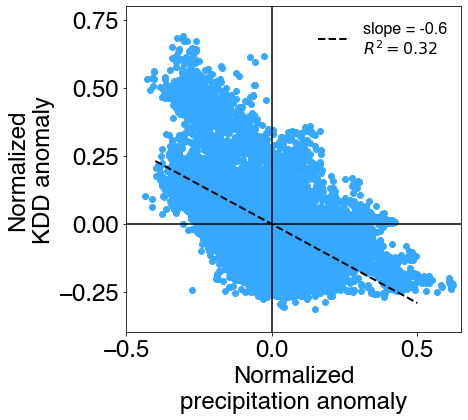

In [124]:
X = sm.add_constant(data['Pr'])
mdl = sm.OLS(data['KDD'], X).fit()

x1 = -.4
x2 = .5

plt.figure(figsize=(6,6))
plt.xlim([-.5, .65])
plt.ylim([-.4, .8])
plt.scatter(data['Pr'], data['KDD'], c = '#36a8ff')
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'slope = -0.6\n$R^2=0.32$')
plt.plot([-.5, .65], [0, 0], '-k')
plt.plot([0, 0], [-.4, .8], '-k')
plt.xlabel('Normalized\nprecipitation anomaly', fontsize=24)
plt.ylabel('Normalized\nKDD anomaly', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='upper right')
l1.get_frame().set_linewidth(0)

plt.savefig('kdd-per-mm.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

In [108]:
mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     5335.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:56:13   Log-Likelihood:                 13049.
No. Observations:               12493   AIC:                        -2.608e+04
Df Residuals:                   12486   BIC:                        -2.603e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0503      0.003    -16.854      0.000      -0.056      -0.044
TotalProd      0.3269      0.018     17.982      0.000       0.291       0.362
Pr             0.4443      0.006     72.857      0.000       0.432       0.456
NetRad         1.4589      0.014    102.627      0.000       1.431       1.487
KDD           -0.2457      0.006    -38.749      0.000      -0.258      -0.233
U10           -0.1084      0.005    -22.238      0.000      -0.118      -0.099
V10           -0.0261      0.005     -5.212      0.000      -0.036      -0.016
==============================================================================
Omnibus:                      668.231   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2302.005
Skew:                          -0.177   Prob(JB):                         0.00
Kurtosis:                       5.073   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
seasonalSeconds = np.array(list(curCountyList['seasonalSeconds']))
kddAnomAgg = np.array(list(curCountyList['kddDetrend']))[adjNn, :]
slhfAnomAgg = -np.array([np.array(list(curCountyList['seasonalSlhfDetrend']))[i, :]/seasonalSeconds[i] for i in adjNn])
slhfAnomAgg = np.reshape(slhfAnomAgg, [slhfAnomAgg.size,1])
kddAnomAgg = np.reshape(kddAnomAgg, [kddAnomAgg.size,1])

nn = np.where((~np.isnan(slhfAnomAgg)) & (~np.isnan(kddAnomAgg)))[0]
slhfAnomAgg = slhfAnomAgg[nn]
kddAnomAgg = kddAnomAgg[nn]

In [43]:
X = sm.add_constant(slhfAnomAgg)
mdl = sm.OLS(kddAnomAgg, X).fit()

mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     3930.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:41:42   Log-Likelihood:                -72440.
No. Observations:               13260   AIC:                         1.449e+05
Df Residuals:                   13258   BIC:                         1.449e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.088e-14      0.496   2.19e-14      1.000      -0.971       0.971
x1            -5.0991      0.081    -62.686      0.000      -5.259      -4.940
==============================================================================
Omnibus:                      468.482   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              520.233
Skew:                           0.469   Prob(JB):                    1.08e-113
Kurtosis:                       3.249   Cond. No.                         6.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

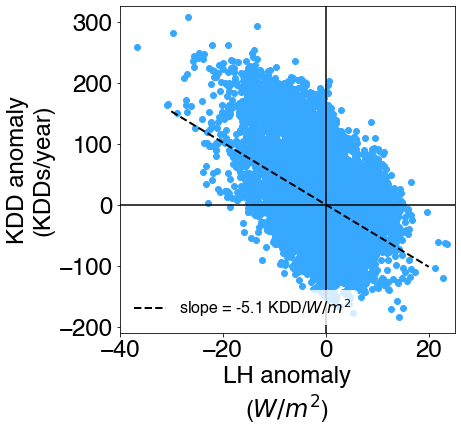

In [44]:
x1 = -30
x2 = 20

plt.figure(figsize=(6,6))
plt.xlim([-40, 25])
plt.ylim([-210, 325])
plt.scatter(slhfAnomAgg, kddAnomAgg, c = '#36a8ff')
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'slope = -5.1 KDD/$W/m^2$')
plt.plot([-40, 40], [0, 0], '-k')
plt.plot([0, 0], [-250, 350], '-k')
plt.xlabel('LH anomaly\n($W/m^2$)', fontsize=24)
plt.ylabel('KDD anomaly\n(KDDs/year)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='lower left')
l1.get_frame().set_linewidth(0)

plt.savefig('kdd-per-lh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

In [45]:
from statsmodels.tsa.stattools import grangercausalitytests

In [46]:
countySlhf = np.array(list(curCountyList['seasonalSlhfDetrendNorm']))

In [47]:
gp_ssr_ftest = []
gp_chi2 = []

for i in range(countyTotalProd.shape[0]):
    nn = np.where((~np.isnan(countyTotalProd[i,:])) & (~np.isnan(countySlhf[i,:])))[0]
    if len(nn) > 10:
        X = np.array([countyTotalProd[i,nn], countySlhf[i,nn]])
        g = grangercausalitytests(X.T, maxlag=[1], verbose=False)
        gp_ssr_ftest.append(g[1][0]['ssr_ftest'][1])
        gp_chi2.append(g[1][0]['ssr_chi2test'][1])
gp_ssr_ftest = np.array(gp_ssr_ftest)
gp_chi2 = np.array(gp_chi2)

In [48]:
gp_chi2[gp_chi2<0.05].size/gp_chi2.size

0.07058823529411765

In [49]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['seasonalPrecipDetrend']))])))
maizeYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['maizeYieldDetrend']))])))
soybeanYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['soybeanYieldDetrend']))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(prAnomAgg)) & (~np.isnan(maizeYieldAnomAgg)) & (~np.isnan(soybeanYieldAnomAgg)))[0]

data = {'GDD':gddAnomAgg[nn], \
        'KDD':kddAnomAgg[nn], \
        'Pr':prAnomAgg[nn], \
        'Pr2':prAnomAgg[nn]**2, \
        'MaizeYield':maizeYieldAnomAgg[nn], \
        'SoybeanYield':soybeanYieldAnomAgg[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'MaizeYield', 'SoybeanYield'])
yieldMdl = smf.ols(formula='MaizeYield ~ GDD + KDD + Pr', data=df).fit()
yieldMdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             MaizeYield   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     6052.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:41:44   Log-Likelihood:            -2.1097e+05
No. Observations:               49144   AIC:                         4.220e+05
Df Residuals:                   49140   BIC:                         4.220e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1251      0.080     -1.564      0.118      -0.282       0.032
GDD            0.0269      0.001     28.620      0.000       0.025       0.029
KDD           -0.1903      0.002   -106.713      0.000      -0.194      -0.187
Pr            -0.3869      0.025    -15.681      0.000      -0.435      -0.339
==============================================================================
Omnibus:                     3361.099   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4961.665
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       4.052   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['kddDetrend']))])))
slhfAnomAgg = -np.array(list(itertools.chain.from_iterable([x for i,x in enumerate(np.array(list(usCounties['seasonalSlhfDetrend'])))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['seasonalPrecipDetrend']))])))
maizeYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['maizeYieldDetrend']))])))
soybeanYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['soybeanYieldDetrend']))])))

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))[adjNn, :]])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))[adjNn, :]])
countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))[adjNn, :]])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))[adjNn, :]])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))[adjNn, :]])
countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))[adjNn, :]])

(array([6.2000e+01, 1.6000e+02, 8.9000e+02, 4.5350e+03, 2.6759e+04,
        4.8257e+04, 6.4690e+03, 5.1800e+02, 5.2000e+01, 9.0000e+00]),
 array([-13.6544566 , -10.99237417,  -8.33029173,  -5.6682093 ,
         -3.00612687,  -0.34404444,   2.31803799,   4.98012043,
          7.64220286,  10.30428529,  12.96636772]),
 <a list of 10 Patch objects>)

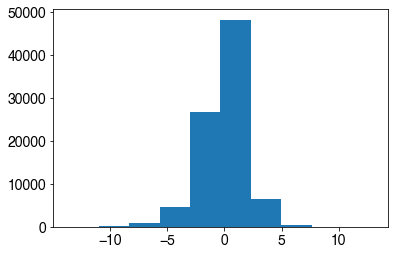

In [32]:
plt.hist(slhfAnomAgg/2260/1000/25.4*)

In [88]:
# try to estimate plant water demand


countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
gddAgg = np.array(list(usCounties['gddDetrend']))[adjNn,:]
kddAgg = np.array(list(usCounties['kddDetrend']))[adjNn,:]
slhfAgg = -np.array(list(usCounties['seasonalSlhfDetrend']))[adjNn,:]
prAgg = np.array(list(usCounties['seasonalPrecip']))[adjNn,:]
maizeYieldAgg = np.array(list(usCounties['maizeYieldDetrend']))[adjNn,:]
maizeHa = np.array(list(usCounties['maizeHarvestedAreaFraction']))[adjNn,:]


# j/growing season/m2 -> mm/growing season/m2
# 2260 lh vaporization (j/g)
slhfAgg /= 2260

# -> mm/m2
slhfAgg /= 1000

# -> in/acre
slhfAgg /= 25.4

slhfAgg = np.reshape(slhfAgg, [slhfAgg.size])
gddAgg = np.reshape(gddAgg, [gddAgg.size])
kddAgg = np.reshape(kddAgg, [kddAgg.size])
prAgg = np.reshape(prAgg, [prAgg.size])
maizeYieldAgg = np.reshape(maizeYieldAgg, [maizeYieldAgg.size])
maizeHa = np.reshape(maizeHa, [maizeHa.size])

slhfAgg *= maizeHa
# slhfAgg *= 0.5


data = {'GDD':gddAgg, \
        'KDD':kddAgg, \
        'Pr':prAgg, \
        'SLHF':slhfAgg, \
        'MaizeYield':maizeYieldAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'SLHF', 'MaizeYield'])
mdl = smf.ols(formula='MaizeYield ~ SLHF+GDD+KDD+Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             MaizeYield   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     2353.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:25:10   Log-Likelihood:                -58972.
No. Observations:               13964   AIC:                         1.180e+05
Df Residuals:                   13959   BIC:                         1.180e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.6597      0.857     32.272      0.000      25.980      29.340
SLHF          10.0832      0.362     27.871      0.000       9.374      10.792
GDD            0.0288      0.002     17.381      0.000       0.026       0.032
KDD           -0.2452      0.004    -65.367      0.000      -0.253      -0.238
Pr            -1.4195      0.044    -32.352      0.000      -1.506      -1.334
==============================================================================
Omnibus:                     1103.935   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1737.261
Skew:                          -0.614   Prob(JB):                         0.00
Kurtosis:                       4.215   Cond. No.                         930.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
gddAgg.shape

(87711,)

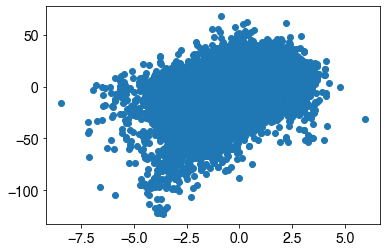

In [52]:
# plt.xlim([15,35])
plt.scatter(slhfAgg, maizeYieldAgg)

In [40]:
# try to estimate plant water demand


countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['kddDetrend']))])))
slhfAnomAgg = -np.array(list(itertools.chain.from_iterable([x for i,x in enumerate(np.array(list(usCounties['seasonalSlhfDetrend'])))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['seasonalPrecipDetrend']))])))
maizeYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['maizeYieldDetrend']))])))

maizeHa = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['maizeHarvestedAreaFraction']))])))

soybeanYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['soybeanYieldDetrend']))])))


# j/growing season/m2 -> mm/growing season/m2
# 2260 lh vaporization (j/g)
slhfAnomAgg /= 2260

# -> mm/m2
slhfAnomAgg /= 1000

# -> mm/acre
slhfAnomAgg *= 4047

# -> in/acre
slhfAnomAgg /= 25.4

data = {'GDD':gddAnomAgg[adjNn], \
        'KDD':kddAnomAgg[adjNn], \
        'Pr':prAnomAgg[adjNn], \
        'SLHF':slhfAnomAgg[adjNn], \
        'MaizeYield':maizeYieldAnomAgg[adjNn], \
        'SoybeanYield':soybeanYieldAnomAgg[adjNn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'SLHF', \
                           'MaizeYield', 'SoybeanYield'])
mdl = smf.ols(formula='MaizeYield ~ SLHF + GDD + KDD + Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             MaizeYield   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     21.95
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           8.34e-16
Time:                        15:55:31   Log-Likelihood:                -1199.5
No. Observations:                 290   AIC:                             2409.
Df Residuals:                     285   BIC:                             2427.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7059      0.898      0.786      0.432      -1.061       2.473
SLHF           0.0010      0.000      3.344      0.001       0.000       0.002
GDD            0.0192      0.010      1.940      0.053      -0.000       0.039
KDD           -0.3270      0.043     -7.565      0.000      -0.412      -0.242
Pr            -0.5495      0.283     -1.939      0.054      -1.107       0.008
==============================================================================
Omnibus:                       32.564   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.259
Skew:                           0.187   Prob(JB):                     1.30e-36
Kurtosis:                       6.679   Cond. No.                     3.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""